In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d

import scipy.fftpack as fft
from scipy import ndimage

from matplotlib.cm import get_cmap

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [2]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input(HMF_CHOICE='ST')
CosmoParams_use,ClassyCosmo_use, CorrFclass_21_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)
AstroParams_use = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY = False,)

ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21_use = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_use, HMFintclass_use, zmin=ZMIN)

RSDMODE = 0 #which RSD mode you want, 0 is no RSDs (real space), 1 is spherical (as simulations usually take), 2 is mu~1 (outside the wedge, most relevant for observations)
PS21_use = zeus21.Power_Spectra(CosmoParams_use, AstroParams_use, ClassyCosmo_use, CorrFclass_21_use, CoeffStructure_21_use, RSD_MODE = RSDMODE)

Lbox = 100
Nbox = 150 

In [3]:
LineParams_input_use = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 2,  
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.)

LineParams_use = zeus21.Line_Parameters(LineParams_input_use) 

CoeffStructure_LIM_use = zeus21.get_LIM_coefficients(CosmoParams_use,  AstroParams_use, HMFintclass_use, LineParams_use, zmin=ZMIN)
CorrFClass_LIM_use = zeus21.Correlations_LIM(LineParams_use, CosmoParams_use, ClassyCosmo_use)
PSLIM_use = zeus21.Power_Spectra_LIM(CosmoParams_use, AstroParams_use, LineParams_use, CorrFClass_LIM_use, 'here we will put 21cm coeffs', CoeffStructure_LIM_use, RSD_MODE = RSDMODE)


In [4]:
def Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, input_delta_array, input_sigmaR):

    if use_interpolation:
        sigmaR = HMFintclass.sigmaRintlog((np.log(R0), z0))

        Nsigmad = 2.0 #how many sigmas we explore
        Nds = 1001 #how many deltas

        # Create a log-spaced array for positive values
        pos = np.logspace(-10, np.log10(Nsigmad), int(Nds/2))  
        neg = -pos[::-1]  # Mirror for negative side
        # Combine negative and positive parts
        deltatab_norm = np.concatenate((neg, pos))

        deltaArray = deltatab_norm * sigmaR
    
    else:
        deltaArray = input_delta_array * input_sigmaR
        sigmaR = input_sigmaR
    
    mArray, deltaArray_Mh = np.meshgrid(HMFintclass.Mhtab, deltaArray, indexing = 'ij', sparse = True)

    sigmaM = HMFintclass.sigmaintlog((np.log(mArray),z0))

    modSigmaSq = sigmaM**2 - sigmaR**2
    indexTooBig = (modSigmaSq <= 0.0)
    modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
    modSigma = np.sqrt(modSigmaSq)

    nu0 = CosmoParams.delta_crit_ST / sigmaM
    nu0[indexTooBig] = 1.0
    modd = CosmoParams.delta_crit_ST - deltaArray_Mh
    nu = modd / modSigma

    EPS_HMF_corr = (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray_Mh)

    HMF_curr = np.exp(HMFintclass.logHMFint((np.log(mArray),z0)))
    SFRtab_currII = zeus21.sfrd.SFR_II(AstroParams, CosmoParams, HMFintclass, mArray, z0, 0.)

    integrand = EPS_HMF_corr *  HMF_curr * SFRtab_currII * HMFintclass.Mhtab[:,np.newaxis]

    integrand_LIM = EPS_HMF_corr *  HMF_curr * LIM.LineLuminosity(SFRtab_currII, LineParams, AstroParams, CosmoParams, HMFintclass, mArray, z0)  * HMFintclass.Mhtab[:,np.newaxis]

    SFRDbox_flattend = np.trapezoid(integrand, HMFintclass.logtabMh, axis = 0) 

    Lbox_flattened = np.trapezoid(integrand_LIM,HMFintclass.logtabMh, axis = 0)

    if use_interpolation:

        interpolate_funct = interp1d(deltaArray, SFRDbox_flattend, kind='cubic',bounds_error=True)

        SFRDbox_flattend = interpolate_funct(input_delta_array * input_sigmaR)

        interpolate_LIM_funct = interp1d(deltaArray, Lbox_flattened, kind='linear',bounds_error=True)

        Lbox_flattened = interpolate_LIM_funct(input_delta_array * input_sigmaR)


    return SFRDbox_flattend, Lbox_flattened

In [5]:
def all_boxes(z0,Lbox,Nbox,PS,CoeffStructure21, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation):
    
    Mapz12 = zeus21.CoevalMaps(CoeffStructure21, PS, z0, KIND=1,Lbox=Lbox,Nbox=Nbox) #can set Lbox, Nbox, and seed

    delta_box = Mapz12.deltamap
    variance = np.var(delta_box)
    sigmaR = np.sqrt(variance)

    R0 = Lbox / Nbox
    SFRDbox_flattend, Lbox_flattend = Interpolation_SFRD_delta(z0, R0, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, delta_box.flatten(), sigmaR)

    delta_box_sigmaR = delta_box * sigmaR
    SFRD_box = SFRDbox_flattend.reshape(Nbox,Nbox,Nbox)
    L_box = Lbox_flattend.reshape(Nbox,Nbox,Nbox)

    if LineParams.LINE == 'CO':
        nu_line_rest = -1
    elif LineParams.LINE == 'CII':
        nu_line_rest = LineParams.CII_nu_rest
    else:
        nu_line_rest = -1

    if LineParams.OBSERVABLE_LIM == 'Tnu':

        # c1 = uK / Lsun * Mpc^3
        coeff1_LIM = (((zeus21.constants.c_kms * LIM.au.km/LIM.au.s)**3 * (1+z0)**2 / (8*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * (nu_line_rest * LIM.au.Hz)**3 * LIM.ac.k_B)).to(LIM.au.uK * LIM.au.Mpc**3 / LIM.au.Lsun )).value

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1.

        # --> c1*c2 = uK

    elif LineParams.OBSERVABLE_LIM == 'Inu':

        # nu_rest for CII is in Hz, speed of light in km / s , Hubble in km / s / Mpc --> c1 = cm / sr / Hz
        coeff1_LIM = ((zeus21.constants.c_kms * LIM.au.km/LIM.au.s) / (4*np.pi * (zeus21.cosmology.Hub(CosmoParams, z0) * LIM.au.km/LIM.au.s/LIM.au.Mpc) * nu_line_rest * LIM.au.Hz)) * zeus21.constants.Mpctocm

        # c2 = Lbar = Lsun / Mpc^3 
        coeff2_LIM = 1. / zeus21.constants.Mpctocm**3

    Inu_box = L_box * coeff1_LIM * coeff2_LIM 

    return delta_box_sigmaR, SFRD_box, L_box, Inu_box

In [6]:
zv = 10.

map_delta, map_SFRD, map_rhoLIM, map_InuLIM = all_boxes(zv,Lbox,Nbox,PS=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,AstroParams=AstroParams_use,LineParams = LineParams_use, use_interpolation = False)

map_delta_interp, map_SFRD_interp, map_rhoLIM_interp, map_InuLIM_interp = all_boxes(zv,Lbox,Nbox,PS=PS21_use,CoeffStructure21=CoeffStructure_21_use,CosmoParams=CosmoParams_use,HMFintclass=HMFintclass_use,LineParams = LineParams_use, AstroParams=AstroParams_use,use_interpolation = True)


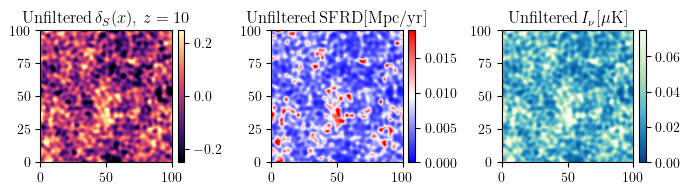

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7,2))

_islice = 0

im = ax[0].imshow(map_delta[_islice],extent=(0,Lbox,0,Lbox),cmap='magma',vmax =0.25, vmin = -0.25) 
cbar1 = fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title(r'${\rm Unfiltered}\,\delta_S(x),\,z=%g$'%zv)

# im = ax[0,1].imshow(map_delta_interp[_islice],extent=(0,Lbox,0,Lbox),cmap='magma',vmax =0.25, vmin = -0.25)
# cbar1 = fig.colorbar(im, ax=ax[0,1], fraction=0.046, pad=0.04)
# ax[0,1].set_title(r'${\rm Interpolated}\,\delta_S(x)$')

# im = ax[0,2].imshow(100.*(map_delta[_islice]-map_delta_interp[_islice])/map_delta[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[0,2], fraction=0.046, pad=0.04)
# ax[0,2].set_title(r'$[\delta_S(x)-{\rm interp}]/\delta_S (\%)$')

im = ax[1].imshow((map_SFRD[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr',vmax=0.019,vmin=0.)
cbar1 = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title(r'${\rm Unfiltered}\,{\rm SFRD} [{\rm Mpc/yr}]$')

# im = ax[1,1].imshow((map_SFRD_interp[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr',vmax=0.025,vmin=0.)
# cbar1 = fig.colorbar(im, ax=ax[1,1], fraction=0.046, pad=0.04)
# ax[1,1].set_title(r'${\rm Interpolated}\,{\rm SFRD} [{\rm Mpc/yr}]$')

# im = ax[1,2].imshow(100*(map_SFRD[_islice]-map_SFRD_interp[_islice])/map_SFRD[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[1,2], fraction=0.046, pad=0.04)
# ax[1,2].set_title(r'$[{\rm SFRD\,-\,interp]/SFRD}(\%)$')

# im = ax[2,0].imshow((map_rhoLIM[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'))
# cbar1 = fig.colorbar(im, ax=ax[2,0], fraction=0.046, pad=0.04)
# ax[2,0].set_title(r'${\rm Unfiltered}\,{\rho_L}(z=%g$'%10.+r'$.{x})$')

# im = ax[2,1].imshow((map_rhoLIM_interp[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'))
# cbar1 = fig.colorbar(im, ax=ax[2,1], fraction=0.046, pad=0.04)
# ax[2,1].set_title(r'${\rm Interpolated}\,{\rho_L}(z=%g$'%10.+r'$.{x})$')

# im = ax[2,2].imshow(100*(map_rhoLIM[_islice]-map_rhoLIM_interp[_islice])/map_rhoLIM[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[2,2], fraction=0.046, pad=0.04)
# ax[2,2].set_title(r'$[{\rho_L\,-\rm \,interp]/\rho_L}(\%)$')

im = ax[2].imshow((map_InuLIM[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),vmax=0.075,vmin=0.)
cbar1 = fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
ax[2].set_title(r'${\rm Unfiltered}\,{I_\nu} [\mu{\rm K}]$')

# im = ax[2,1].imshow((map_InuLIM_interp[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),vmax=0.1,vmin=0.)
# cbar1 = fig.colorbar(im, ax=ax[2,1], fraction=0.046, pad=0.04)
# ax[2,1].set_title(r'${\rm Interpolated}\,{I_\nu} [\mu {\rm K}]$')

# im = ax[2,2].imshow(100*(map_InuLIM[_islice]-map_InuLIM_interp[_islice])/map_InuLIM[_islice],extent=(0,Lbox,0,Lbox),cmap='grey')
# cbar1 = fig.colorbar(im, ax=ax[2,2], fraction=0.046, pad=0.04)
# ax[2,2].set_title(r'$[{I_\nu\,-\rm \,interp]/I_\nu}(\%)$')

plt.tight_layout()
plt.savefig('./plots/all_boxes_' + str(zv) + '.png')
plt.show()


In [8]:
def top_hat_filter(k, R):
    """Top-hat filter in k-space, avoiding division by zero."""
    kR = k * R
    W = np.zeros_like(k)
    mask = kR > 0
    W[mask] = 3 * (np.sin(kR[mask]) - kR[mask] * np.cos(kR[mask])) / (kR[mask]**3)
    W[~mask] = 1.0  # Ensure W(0) = 1
    
    return W

In [9]:
def smoothed_boxes(z0,R0,Lbox,Nbox,PS,CoeffStructure, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation, smooth_type):

    density_vals, SFRD_box_vals, rhoL_box_vals, Inu_box_vals = all_boxes(z0,Lbox,Nbox,PS,CoeffStructure, LineParams, AstroParams, HMFintclass, CosmoParams, use_interpolation)
    
    if 2*R0 < Lbox/Nbox:
        print('\n\nYou cannot smooth over R smaller than the cell size!!!\n\n')
        return density_vals,SFRD_box_vals,rhoL_box_vals, Inu_box_vals
    elif 2*R0 > Lbox:
        print('\n\nYou cannot smooth over R larger than the box size!!!\n\n')
        return density_vals,SFRD_box_vals,rhoL_box_vals, Inu_box_vals
 
    input_ = fft.fftn(density_vals)
    input_SFRD = fft.fftn(SFRD_box_vals)
    input_rhoL = fft.fftn(rhoL_box_vals)
    input_Inu = fft.fftn(Inu_box_vals)

    if smooth_type == 'gauss':

        result_fft = ndimage.fourier_gaussian(input_, sigma= R0 )
        density_smoothed_R = np.abs(np.fft.ifftn(result_fft)) * np.sign(density_vals)

        result_fft_SFRD = ndimage.fourier_gaussian(input_SFRD, sigma= R0 )
        SFRD_smoothed_R = np.abs(np.fft.ifftn(result_fft_SFRD)) * np.sign(SFRD_box_vals)

        result_fft_rhoL = ndimage.fourier_gaussian(input_rhoL, sigma= R0 )
        rhoL_smoothed_R = np.abs(np.fft.ifftn(result_fft_rhoL)) * np.sign(rhoL_box_vals)

        result_fft_Inu = ndimage.fourier_gaussian(input_Inu, sigma= R0 )
        Inu_smoothed_R = np.abs(np.fft.ifftn(result_fft_Inu)) * np.sign(Inu_box_vals)

    elif smooth_type == 'tophat':

        N = density_vals.shape[0]  # Assuming cubic box
        dx = len(density_vals) / N  # Grid spacing
        k_freq = 2 * np.pi * fft.fftfreq(N, d=dx)  # Correct k definition
        
        # Create a 3D grid of k values
        kx, ky, kz = np.meshgrid(k_freq, k_freq, k_freq, indexing="ij")
        k_mag = np.sqrt(kx**2 + ky**2 + kz**2)
        
        # Apply filter
        input_ *= top_hat_filter(k_mag, R0)
        density_smoothed_R = fft.ifftn(input_).real

        input_SFRD *= top_hat_filter(k_mag, R0)
        SFRD_smoothed_R = fft.ifftn(input_SFRD).real

        input_rhoL *= top_hat_filter(k_mag, R0)
        rhoL_smoothed_R = fft.ifftn(input_rhoL).real

        input_Inu *= top_hat_filter(k_mag, R0)
        Inu_smoothed_R = fft.ifftn(input_Inu).real

    return np.asarray(density_smoothed_R), np.asarray(SFRD_smoothed_R), np.asarray(rhoL_smoothed_R), np.asarray(Inu_smoothed_R)

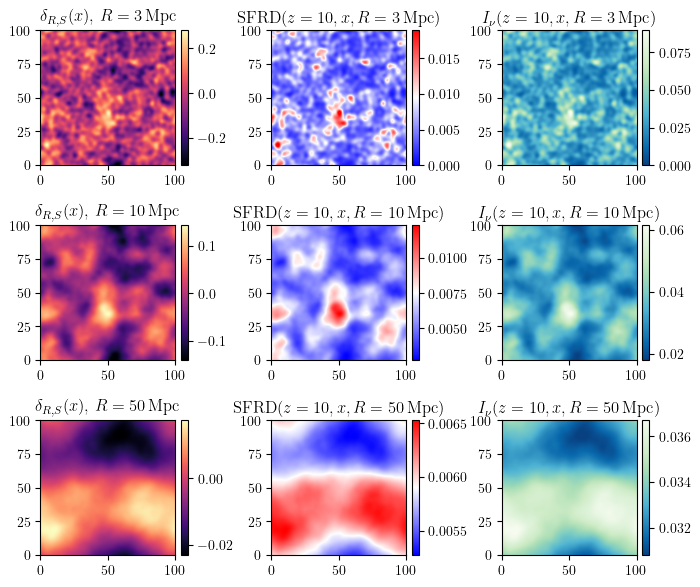

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7, 6))
R_vals = [3,10,50]
z0 = 10.
for r in range(len(R_vals)):

    smoothed_map_delta_z, smoothed_map_SFRD, smoothed_map_rhoL, smoothed_map_Inu  = smoothed_boxes(z0, R_vals[r],Lbox,Nbox,PS21_use,CoeffStructure_21_use, LineParams_use, AstroParams_use, HMFintclass_use, CosmoParams_use, use_interpolation = False, smooth_type='tophat')
    
    _islice = 0

    im = ax[r,0].imshow((smoothed_map_delta_z[_islice]),extent=(0,Lbox,0,Lbox),cmap='magma')#,vmax =0.25, vmin = -0.25) 
    cbar1 = fig.colorbar(im, ax=ax[r,0], fraction=0.046, pad=0.04)
    ax[r,0].set_title(r'$\delta_{R,S}(x),\,R=%g\,{\rm Mpc}$'%R_vals[r])

    if r == 0:
        im = ax[r,1].imshow((smoothed_map_SFRD[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr',vmax=0.019,vmin=0)
    else:
        im = ax[r,1].imshow((smoothed_map_SFRD[_islice]),extent=(0,Lbox,0,Lbox),cmap='bwr')
    cbar1 = fig.colorbar(im, ax=ax[r,1], fraction=0.046, pad=0.04)
    ax[r,1].set_title(r'${\rm SFRD}(z=%g$'%z0+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])

    # im = ax[r,2].imshow((smoothed_map_rhoL[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),)
    # cbar1 = fig.colorbar(im, ax=ax[r,2], fraction=0.046, pad=0.04)
    # ax[r,2].set_title(r'$\log_{10}\rho_{L}(z=%g$'%z0+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])

    if r == 0:
        im = ax[r,2].imshow((smoothed_map_Inu[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),vmin=0.,vmax = 0.09)
    else:
        im = ax[r,2].imshow((smoothed_map_Inu[_islice]),extent=(0,Lbox,0,Lbox),cmap=get_cmap('GnBu_r'),)
    cbar1 = fig.colorbar(im, ax=ax[r,2], fraction=0.046, pad=0.04)
    ax[r,2].set_title(r'${I_\nu}(z=%g$'%z0+r'$,{x},R=%g\,{\rm Mpc})$'%R_vals[r])


plt.tight_layout()
plt.savefig('./plots/filtered_boxes.png')
plt.show()


#### The next functions are to compare the smoothing with the lognormal approximation

In [11]:
def SFRD_approx(tilde_deltaArray, CoeffStructure_21):

    use_gamma = CoeffStructure_21.gamma_II_index2D 
    SFRD_deltaR =  np.exp(use_gamma[:,:,np.newaxis] * tilde_deltaArray)

    return SFRD_deltaR

In [12]:
#def SFRD_from_deltaR(CoeffStructure_21,CosmoParams,HMFintclass,AstroParams,Nsigmad = 1.0,Nds = 2):
def SFRD_from_deltaR(CoeffStructure_21):

    SFRD_II_dR = CoeffStructure_21.SFRD_II_dR

    return SFRD_II_dR

In [13]:
def binned_SFRD_R(delta_box, delta_R, sfr):

    # Step 1: Calculate the bin edges based on delta_R central points
    bin_edges = np.zeros(len(delta_R) + 1)
    bin_edges[0] = delta_R[0] - (delta_R[1] - delta_R[0]) / 2  # Edge before first central point
    bin_edges[-1] = delta_R[-1] + (delta_R[-1] - delta_R[-2]) / 2  # Edge after last central point

    # Fill the interior edges (midpoints between consecutive central points)
    for i in range(1, len(delta_R)):
        bin_edges[i] = (delta_R[i-1] + delta_R[i]) / 2

    # Step 2: Use np.digitize to get the bin indices for delta values based on bin_edges
    bin_indices = np.digitize(delta_box, bin_edges) - 1  # Subtract 1 to get correct indices (1-based to 0-based)

    # Step 3: Initialize a new array to store binned sfr values (based on delta's bins)
    binned_sfr = np.zeros((len(delta_R), *delta_box.shape))  # One bin for each central point in delta_R
    binned_sfr_mean = np.zeros((len(delta_R)))  # One bin for each central point in delta_R

    # Step 4: Bin the sfr values according to the bin indices of delta
    for i in range(len(delta_R)):
        binned_sfr[i] = np.where(bin_indices == i, sfr, 0)  # Assign sfr values to corresponding bins

    # Now, binned_sfr contains the values of sfr binned according to delta
    # Each element in binned_sfr[i] corresponds to the sfr values that fall into the ith bin of delta_R

        # Optionally: You can aggregate the values in each bin, e.g., by computing the mean
        binned_sfr_mean[i] = np.max(binned_sfr[i])

    return binned_sfr_mean


In [14]:
digitized = [
[    -0.39328866282070507, 0.03129484349],
[-0.3825608839444984, 0.0344495057459261],
[-0.3650074650773033, 0.0409621890428302],
[-0.3474540462101082, 0.0487060959177615],
[-0.33672606952939843, 0.053465756322284],
[-0.3259985873599466, 0.0591034252758564],
[-0.31624564951564094, 0.064120512143562],
[-0.2996673079468369, 0.0753921067013631],
[-0.2821134824814964, 0.0891297630569916],
[-0.27138520909403185, 0.097429039795554],
[-0.26065757857120253, 0.107476124094796],
[-0.2509046462214665, 0.1166084858595768],
[-0.23383821173876534, 0.136798792045157],
[-0.21579635792071977, 0.161510152398993],
[-0.2050679856310036, 0.1763017361795231],
[-0.1943401078525454, 0.1938018383619663],
[-0.18458704912771007, 0.209893023236297],
[-0.16752035777388324, 0.245340157366855],
[-0.14947814543517574, 0.288190003119008],
[-0.1387495753409564, 0.3137024117291812],
[-0.12802154920912073, 0.344116738818438],
[-0.11778042380695786, 0.371989472011956],
[-0.10022547937253212, 0.432850976848566],
[-0.08315904282936737, 0.507782609063308],
[-0.0724302254795191, 0.5508007184651427],
[-0.061701902640928674, 0.60166633816386],
[-0.05097323364445777, 0.654012052832660],
[-0.03341814992269432, 0.759514307828508],
[-0.014886126243468412, 0.86873968625253],
[-0.0041578198885866, 0.9491882701599547],
[0.006566893017820874, 1.091286362885962],
[0.01583243095081177, 1.1749875482882401],
[0.03338929285264014, 1.3305641254970535],
[0.05143243239995621, 1.5425440245671316],
[0.06216159590768511, 1.665033839669942],
[0.0728901165507787, 1.813704223561651],
[0.08361898335175277, 1.9659781447457958],
[0.10166207962933393, 2.280588031374602],
[0.11970515118135205, 2.6464715100158913],
[0.13043411688457773, 2.8646431942559136],
[0.14116273642992294, 3.1160543775639358],
[0.15189199883990334, 3.3587804470976304],
[0.16993527437781542, 3.8863877218661322],
[0.1879783150228801, 4.5118722191121545],
[0.19870737962835727, 4.876982490051713],
[0.20943614752707984, 5.2938584628605625],
[0.21967752018487174, 5.7026262065197795],
[0.23772096226711104, 6.582851479248956],
[0.2562522700824207, 7.606328791995048],
[0.26698148304127534, 8.20457589823058],
[0.2777102509399978, 8.905888762493632],
[0.28795170766470346, 9.582134755962688],
[0.30648322776663184, 11.038659412447359],
[0.32452671965321933, 12.733531184387346],
[0.3352560315143256, 13.715795163714528],
[0.345985046668677, 14.836103334052082],
[0.35671425962753167, 16.002981092051286],
[0.3747577824210727, 18.45198660747315],
[0.39328958810325243, 21.170882800120474],
]

digitized = np.asanyarray(digitized).T

In [15]:
digitized_10 = [
[    -0.39269736877844025, 0.102074818791],
[-0.3504837456745368, 0.12993087842004172],
[-0.2829422384305743, 0.19194027347742817],
[-0.18877452906548264, 0.3341710204317160],
[-0.10175064689553509, 0.5583856196659748],
[-0.047198113907937045, 0.767666869892733],
[0.056712231531562685, 1.3925561288744635],
[0.18594937465255978, 2.9771557869292153],
[0.2781687016639114, 5.130325584896997],
[0.3216810049017389, 6.597782479539529],
[0.39181987241354965, 9.948791873023238],
]

digitized_10 = np.asanyarray(digitized_10).T


In [18]:
def compare_SFRD(R, z_vals, Lbox, Nbox, CoeffStructure_21,CosmoParams,HMFintclass):

    z_array = CoeffStructure_21.zintegral

    deltatab_norm_code = np.linspace(-1,1,3)
    deltatab_norm = np.linspace(-3,3,200)

    zArray_big, rArray, mArray, deltaNormArray = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)
    deltaNormArray_code = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm_code, indexing = 'ij', sparse = True)[-1]

    rGreaterArray = np.zeros_like(zArray_big) + rArray

    rGreaterArray[CosmoParams.chiofzint(zArray_big) + rArray >= CosmoParams.chiofzint(50)] = np.nan
    
    zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray_big) + rGreaterArray)

    whereNotNans = np.invert(np.isnan(rGreaterArray))
    sigmaR = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), 1, 1))
    sigmaR[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans]))

    R_idx = np.argmin(np.abs(CoeffStructure_21.Rtabsmoo - R)) 

    # deltaArray = np.squeeze(deltaNormArray * sigmaR )
    # deltaArray_code = np.squeeze(deltaNormArray_code * sigmaR)

    # # pass delta and not tilde_delta to the interp since the change is done inside the function itself
    # SFRD_approx_val_z =  SFRD_approx(deltaArray,CoeffStructure_21)

    SFRD_Zeus_all = SFRD_from_deltaR(CoeffStructure_21)
    bar_SFRD = CoeffStructure_21.SFRD_II_avg

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

    for z in z_vals:

        z_idx = np.argmin(np.abs(z_array - z)) 

        gamma = CoeffStructure_21.gamma_II_index2D[z_idx,R_idx]

        deltaArray = np.squeeze(deltaNormArray * sigmaR - gamma * sigmaR**2/2.)
        deltaArray_code = np.squeeze(deltaNormArray_code * sigmaR - gamma * sigmaR**2/2.)

        SFRD_approx_val_z =  SFRD_approx(deltaArray,CoeffStructure_21)

        smoothed_map_delta_R, smoothed_map_SFRD, map_rhoLIM, map_Inu_LIM = smoothed_boxes(z,R,Lbox,Nbox,PS21_use,CoeffStructure_21_use, LineParams_use, AstroParams_use, HMFintclass_use, CosmoParams_use, False, 'tophat')    

        # delta is binned over the tilde_delta array to make the histogram
        smoothed_map_delta_R -= gamma * np.var(smoothed_map_delta_R)/2.
        SFRD_smooth_z = binned_SFRD_R(smoothed_map_delta_R, deltaArray[z_idx,R_idx], smoothed_map_SFRD) / np.mean(smoothed_map_SFRD)

        normalize_delta = 1. + deltaArray_code[z_idx,R_idx]

        # # interpolate over delta but then reapply to tilde_delta
        SFRD_Zeus_z = 10**interp1d(deltaArray_code[z_idx,R_idx], np.log10(SFRD_Zeus_all[z_idx,R_idx]/ normalize_delta), bounds_error=False, fill_value='extrapolate',kind='linear')(deltaArray[z_idx,R_idx]) /  bar_SFRD[z_idx] 

        # if int(R) == 3:
        #     if z == 15:
        #         ax[z_vals.index(z)].semilogy(digitized[0],digitized[-1],label=r'$\rm paper$',color='k',linestyle=':')
        #     elif z == 10:
        #         ax[z_vals.index(z)].semilogy(digitized_10[0],digitized_10[-1],label=r'$\rm paper$',color='k',linestyle=':')

        xval = np.squeeze(deltaArray[z_idx,R_idx])#/sigmaR[z_idx,R_idx])

        ax[z_vals.index(z)].semilogy(xval,SFRD_Zeus_z,label=r'$\rm Full$',color=colors[2],linestyle='-')
        ax[z_vals.index(z)].semilogy(xval,SFRD_approx_val_z[z_idx,R_idx],label=r'$\rm Approximation$',color=colors[-2],linestyle='-')
        ax[z_vals.index(z)].semilogy(xval,SFRD_smooth_z,color=colors[0],ls='-', label=r'$\rm Smoothed$')

        ax[z_vals.index(z)].set_title(r'$z=%g$'%z + r'$, R =%g {\rm Mpc}$'%R)
        ax[z_vals.index(z)].legend(loc=2)
        ax[z_vals.index(z)].set_ylabel(r'$\rm SFRD(z|\delta_R)/\overline{SFRD}(z)$')
        ax[z_vals.index(z)].set_xlabel(r'$\tilde{\delta}_R$') #/\sigma_R$')
        # ax[z_vals.index(z)].set_xlim(-0.4,0.4)
        # ax[z_vals.index(z)].set_ylim(1e-2,1e2)

    plt.tight_layout()
    plt.savefig('./plots/compare_R' + str(R) + '.png')
    plt.show()

    return 

Doing R = 3 Mpc


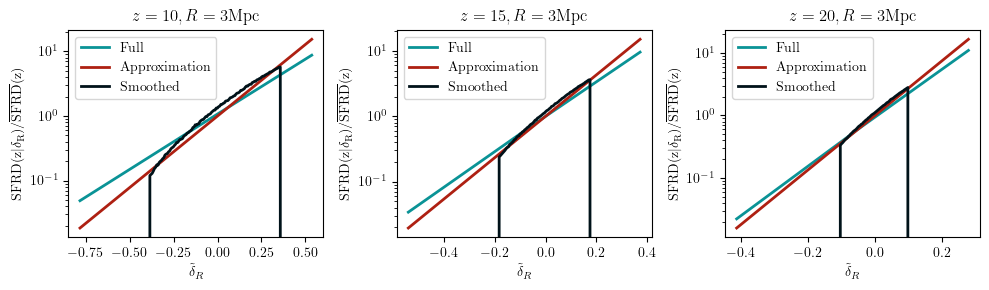

Doing R = 10 Mpc


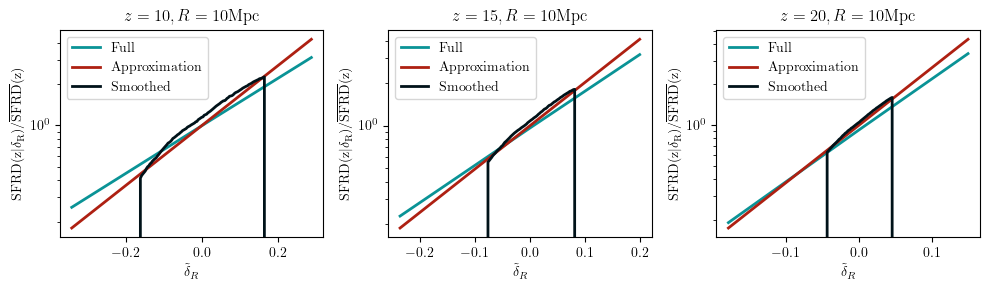

Doing R = 50 Mpc


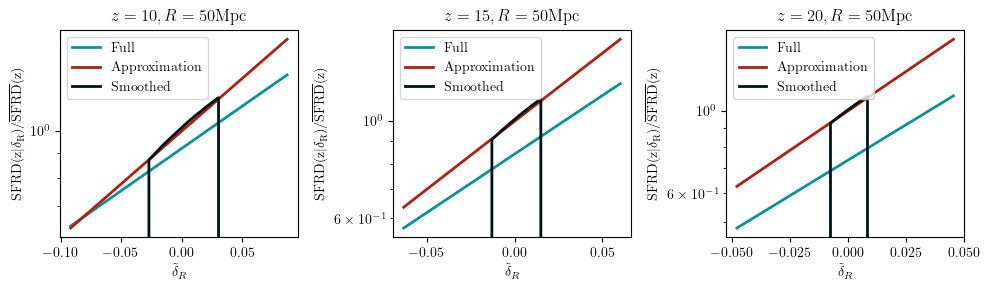

In [19]:
R_vals = [3,10,50]
for R in R_vals:
    print('Doing R = ' + str(R) + ' Mpc')
    compare_SFRD(R, [10,15,20], Lbox, Nbox, CoeffStructure_21_use,CosmoParams_use,HMFintclass_use)